# Coadd Patch Viewer

Simple patch displayer. Uses `lsst.afw.display` to display a specified patch image. The image, maskedImage, and variance image are displayed. If a `deepCoadd_calexp` image exists for the given query, then that image is displayed twice - first without any sources shown, then with sources above a user-specified SNR threshold displayed. If, on the other hand, no `deepCoadd_calexp` image exists, then it attempts to retrieve the `deepCoadd` image, in which case no detected sources are shown as they don't have measured fluxes.

In [1]:
repo = "/repo/ops-rehearsal-3-prep"
collection = "u/mullaney/OR4Prep"
skymap = "ops_rehersal_prep_2k_v1"
tract = 9638
patch = 286
band = "i"
snr = 10

In [2]:
import matplotlib.pyplot as plt

import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

In [3]:
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (9.0, 9.0)

In [4]:
def plotImage(image, sources=None):
    fig = plt.figure()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(image)

    if sources is not None:
        with display.Buffering():
            for source in sources:
                display.dot('o', source.getX(), source.getY(), size=10, ctype='green')

def addTickLabels(coadd):
    wcs = coadd.getWcs()

    x0 = coadd.getX0()
    width = coadd.getWidth()

    y0 = coadd.getY0()
    height = coadd.getHeight()

    xs = range(x0, x0+width, 250)
    ys = range(y0, y0+height, 250)
    
    xlabels = []
    ylabels = []
    for x in xs:
        radec = wcs.pixelToSky(x, ys[0])
        ra = radec.getRa().asDegrees()
        xlabels.append('{:.2f}'.format(ra))
    for y in ys:
        radec = wcs.pixelToSky(xs[0], y)
        dec = radec.getDec().asDegrees()
        ylabels.append('{:.2f}'.format(ra))

    plt.xticks(xs, xlabels)
    plt.yticks(ys, ylabels)


In [5]:
butler = dafButler.Butler(repo, collections=collection)
registry = butler.registry

In [6]:
query=f"skymap='{skymap}' AND tract={tract} AND patch={patch} AND band='{band}'"
coadd_name = 'deepCoadd_calexp'
refs = list(registry.queryDatasets(coadd_name, where=query))
if len(refs) > 0:
    coadd = butler.get(refs[0])
    coadd_obj = butler.get('deepCoadd_meas', dataId=refs[0].dataId)
else:
    print('No deepCoadd_calexp matching the query found; attempting to get deepCoadd instead')
    coadd_name = 'deepCoadd'
    refs = list(registry.queryDatasets(coadd_name, where=query))
    if len(refs) == 0:
        print('No deepCoadd matching the query found; nothing to display.')
    else:
        coadd = butler.get(refs[0])
    

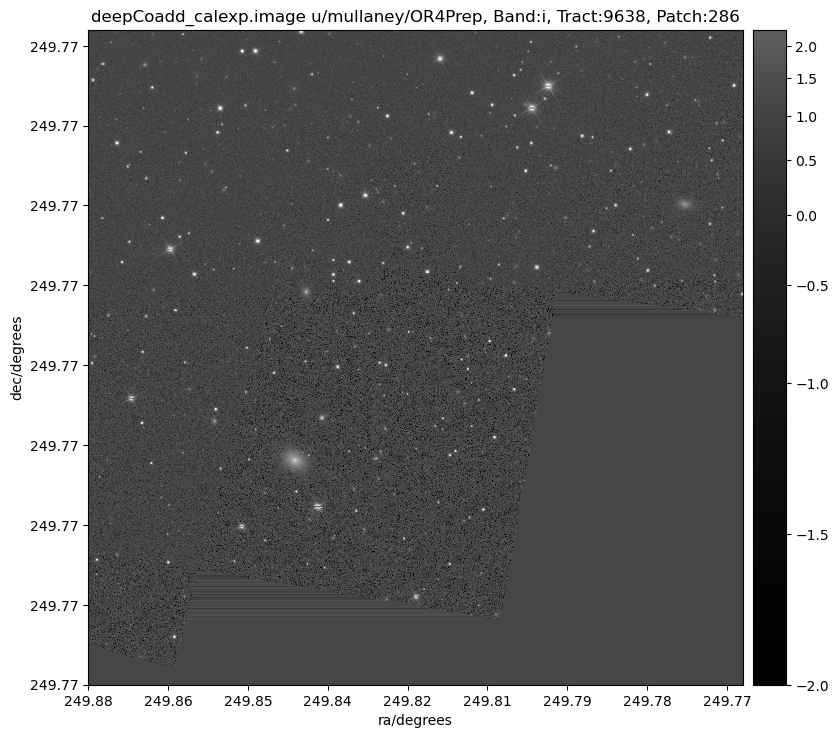

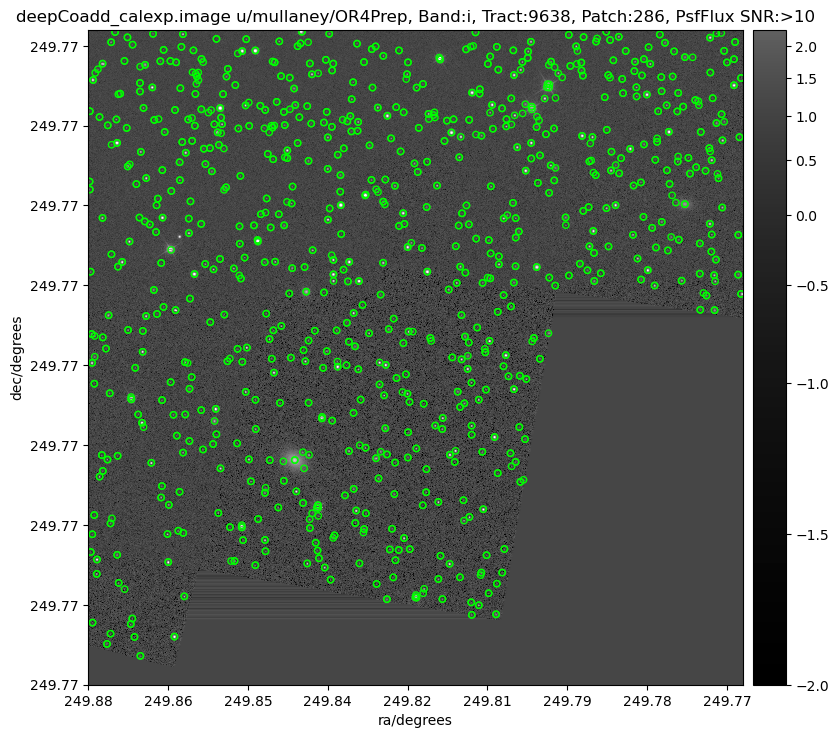

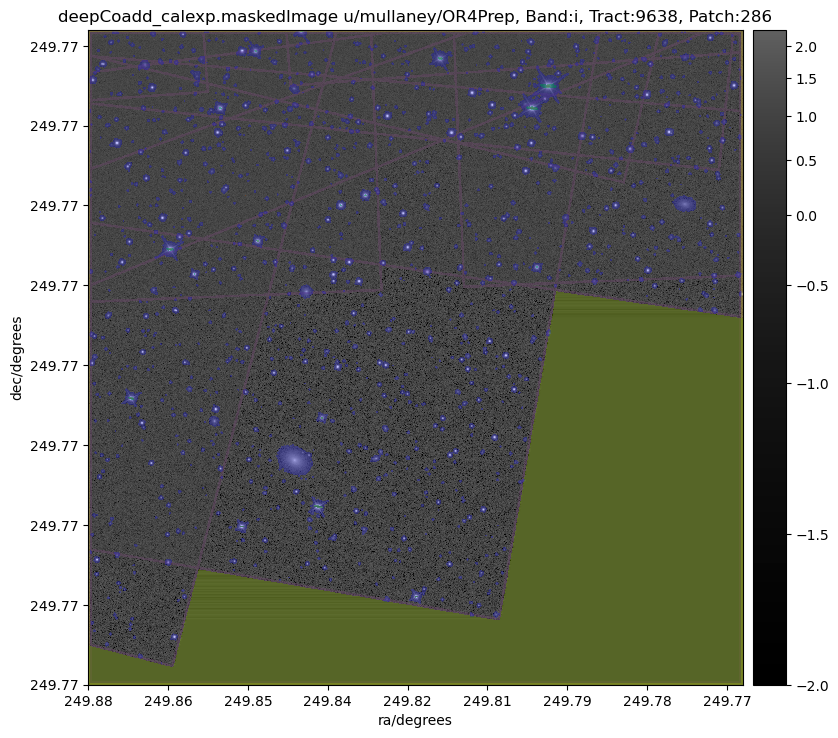

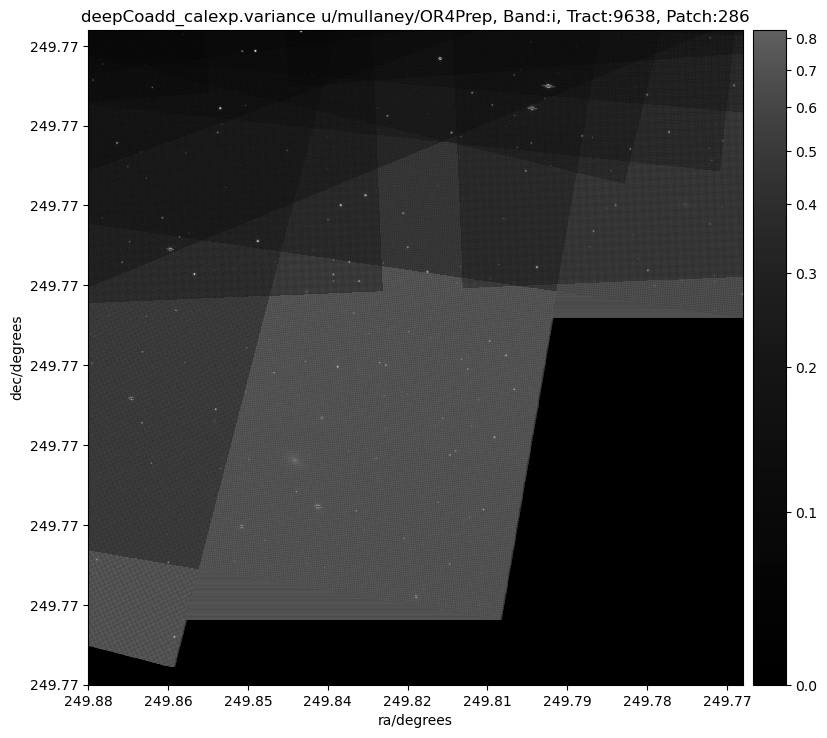

In [7]:
if len(refs) > 0:
    plotImage(coadd.image)
    addTickLabels(coadd)
    plt.title(f"{coadd_name}.image {collection}, Band:{band}, Tract:{tract}, Patch:{patch}")
    plt.xlabel('ra/degrees')
    plt.ylabel('dec/degrees')
    plt.show()

    if coadd_name == 'deepCoadd_calexp':
        srcMask = (coadd_obj.get('base_PsfFlux_instFlux') / 
                   coadd_obj.get('base_PsfFlux_instFluxErr')) >= snr
        sigSrc = coadd_obj[srcMask]
        plotImage(coadd.image, sources=sigSrc)
        addTickLabels(coadd)
        plt.title(f"{coadd_name}.image {collection}, Band:{band}, Tract:{tract}, Patch:{patch}, PsfFlux SNR:>{snr}")
        plt.xlabel('ra/degrees')
        plt.ylabel('dec/degrees')
        plt.show()

    plotImage(coadd.maskedImage)
    addTickLabels(coadd)
    plt.title(f"{coadd_name}.maskedImage {collection}, Band:{band}, Tract:{tract}, Patch:{patch}")
    plt.xlabel('ra/degrees')
    plt.ylabel('dec/degrees')
    plt.show()

    plotImage(coadd.variance)
    addTickLabels(coadd)
    plt.title(f"{coadd_name}.variance {collection}, Band:{band}, Tract:{tract}, Patch:{patch}")
    plt.xlabel('ra/degrees')
    plt.ylabel('dec/degrees')
    plt.show()